RMT Chapter 1 Deterministic Matrices Exercise 1.2.4

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# set random number generator
seed = 24
rng = np.random.default_rng(seed) 

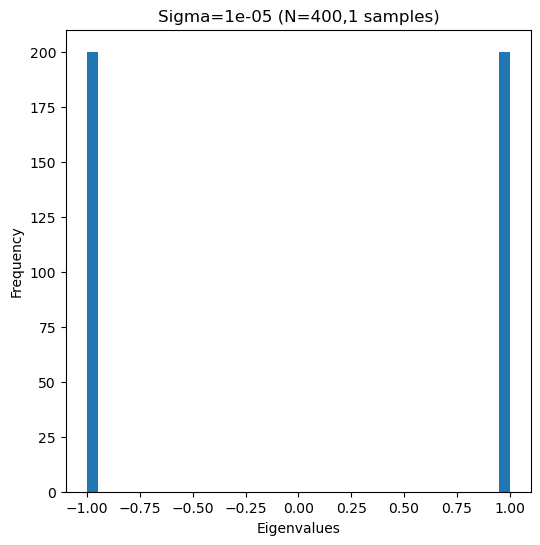

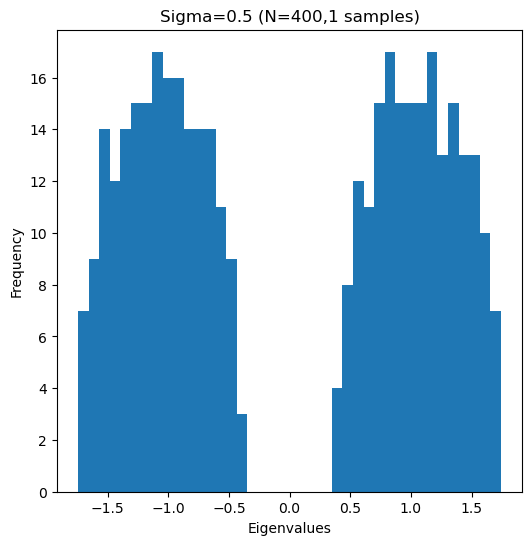

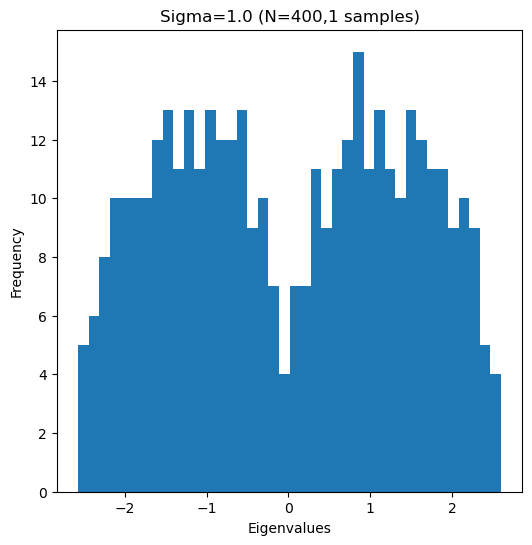

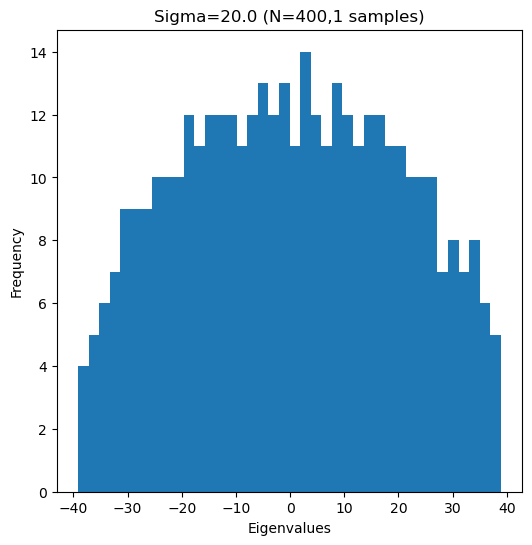

In [138]:
# functions to construct matrices 

# wigner matrix 
def get_wigner(rng, sigma=1.0, N=5):
    H_mean = 0.0
    #H_var = sigma**2 / N
    H = rng.normal(loc=H_mean, scale=1.0, size=(N,N)) # 1 to produce standard gaussians and then multiply sigma later
    X = sigma*(H + H.T) / np.sqrt(2*N)
    return X
# NOTE: are the diagonals the right variance? 

# random symmetric real orthogonal matrix 
def get_real_symmetric_orthogonal(rng, sigma=1.0, N=5, tol=1e-12):
    # get wigner matrix 
    x_ = get_wigner(rng, sigma, N)
    # diagonalise it
    x_lambda, x_v = np.linalg.eigh(x_)
    # get diagonal matrix of eigenvalue signs 
    diag = np.zeros(x_.shape)
    # treat near zeros as + 
    s = np.sign(x_lambda)
    s[np.abs(x_lambda) < tol] = 1.0
    np.fill_diagonal(diag, np.sign(s))

    # reconstruct the matrix 
    M = x_v @ diag @ x_v.T
    return M

def get_E(rng, sigma, N, return_M=False):
    X = get_wigner(rng, sigma,N)
    M = get_real_symmetric_orthogonal(rng, sigma, N)
    E = M + X
    if return_M:
        return E, M
    else:
        return E

def get_E_from_M(rng, M, sigma, N):
    X = get_wigner(rng, sigma,N)
    E = M + X
    return E

def plot_eigenvalue_hist(lambdas, bins=40, title=''):
    fig, ax = plt.subplots(figsize=(6,6))
    ax.hist(lambdas, bins=bins)
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Eigenvalues')
    ax.set_title(title)

N = 400
sigmas = [0.00001, 0.5, 1.0, 20.0] #, 20.0, 40.0]

# single sample
# sigma=70.0
# E = get_E(rng, sigma, N)
# E_lambda, E_v = np.linalg.eigh(E)
# plot_eigenvalue_hist(E_lambda, title='Single sample')

M = get_real_symmetric_orthogonal(rng, sigma=sigmas[0], N=N)

for sg in sigmas:
    # many samples
    n_samples=1
    E_lambda_samples = []
    for samp in range(n_samples):
        E = get_E_from_M(rng, M, sigma=sg, N=N)
        e_lamb, e_v = np.linalg.eigh(E)
        E_lambda_samples.extend(e_lamb)
    plot_eigenvalue_hist(E_lambda_samples, title=f'Sigma={sg} (N={N},{n_samples} samples)')



(b) For large N, expecting non-zero density of eigenvalues near zero from around sigma ~ 1, with larger values increasing density at 0

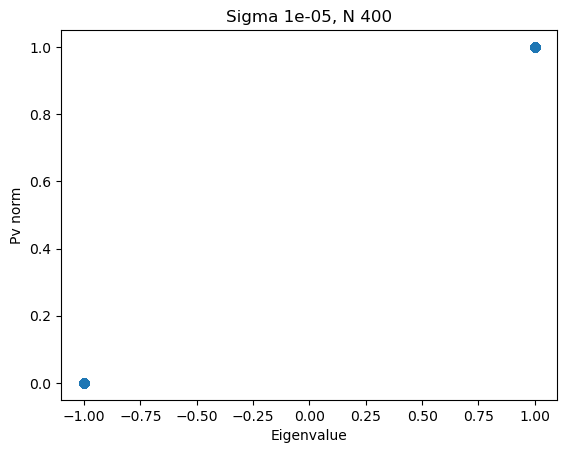

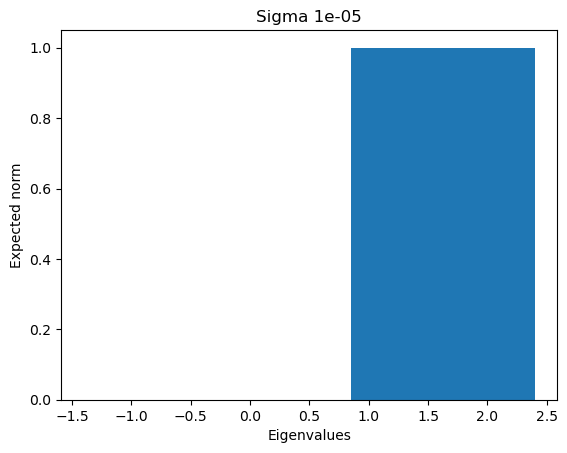

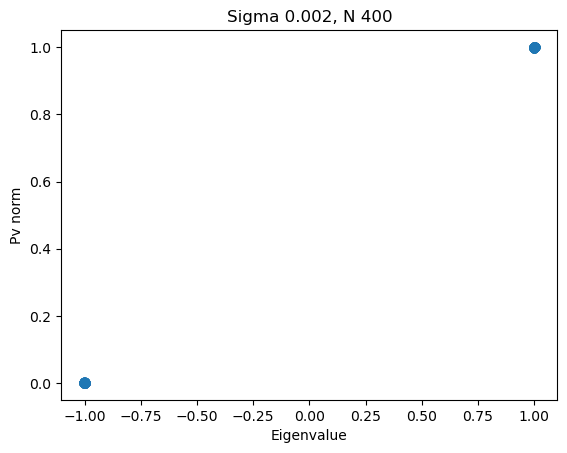

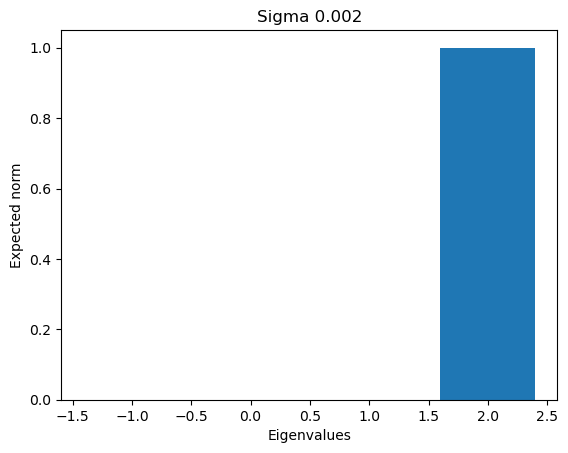

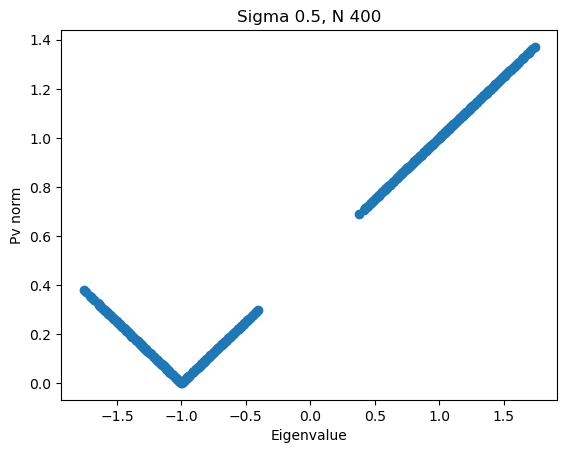

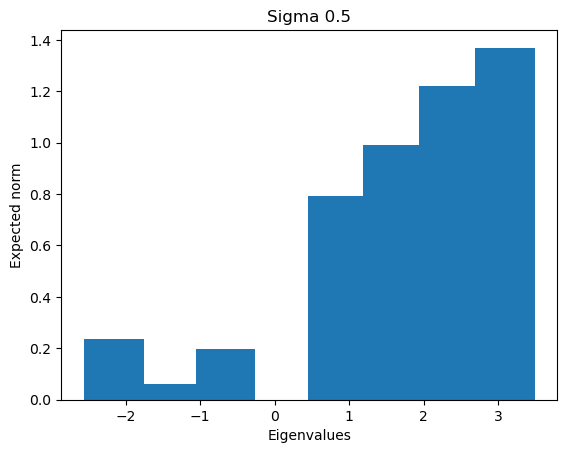

In [139]:
# exercise (c)

def get_Pplus(M):
    n = M.shape[0]
    P = 0.5 * (M + np.eye(n))
    return P

def get_vector_norm(v):
    v_norm = np.sqrt(np.sum(v**2))
    return v_norm

N=400
sigmas = [0.00001, 0.002, 0.5]

M = get_real_symmetric_orthogonal(rng, sigma=sigmas[0], N=N)

n_samples = 5
for sg in sigmas:
    evals = []
    v_norms = []
    for ns in range(n_samples):
        E = get_E_from_M(rng, M, sigma=sg, N=N)
        E_lamb, E_v = np.linalg.eigh(E)
        P = get_Pplus(E)
        for j in range(E_v.shape[1]):
            vi = E_v[:,j]
            Pvi = P @ vi
            vi_norm = get_vector_norm(Pvi)
            v_norms.append(vi_norm)
            evals.append(E_lamb[j])

        # plot example scatter plot once 
        if ns == 0:
            fig, ax = plt.subplots(1,1)
            ax.scatter(E_lamb, v_norms)
            ax.set_xlabel('Eigenvalue')
            ax.set_ylabel('Pv norm')
            ax.set_title(f'Sigma {sg}, N {N}')

    # bin eigenvalues and compute expected per bin 
    bins = np.arange(min(evals), max(evals)+0.5, 0.5)
    bin_indices = np.digitize(evals, bins)
    bin_means = []
    bin_x = []
    for b in range(1, len(bins)):
        vals = [v_norms[i] for i in range(len(v_norms)) if bin_indices[i] == b]

        if len(vals) > 0:
            bin_x.append(0.5 * bins[b-1] + bins[b])
            bin_means.append(np.mean(vals))
    fig, ax = plt.subplots(1,1)
    ax.bar(bin_x, bin_means)
    ax.set_xlabel('Eigenvalues')
    ax.set_ylabel('Expected norm')
    ax.set_title(f'Sigma {sg}')


In [140]:
# (d) build an estimator 

def compute_err(Eest, M):
    N = M.shape[0]
    diff = Eest - M
    err = np.trace(diff @ diff.T) / N
    return err

def estimator(E, func):
    e_lamb, e_v = np.linalg.eigh(E)
    e_lamb_transformed = func(e_lamb) # apply function to eigenvalues 
    E_hat = e_v @ np.diag(e_lamb_transformed) @ e_v.T
    return E_hat

N=400
sigmas = [0.00001, 0.5, 1.0]
for sg in sigmas:
    E, M = get_E(rng, sigma=sg, N=N, return_M=True)
    Eest1 = E
    Eest0 = np.zeros(E.shape)
    func = lambda x: np.sign(x)
    Eest_sign = estimator(E, func)
    
    err1 = compute_err(Eest1, M)
    err0 = compute_err(Eest0, M)
    errsign = compute_err(Eest_sign, M)
    print('Sigma ', sg)
    print('E_hat = E ', err1)
    print('E_hat = 0 ', err0)
    print('E_hat sign(lambda) ', errsign)

Sigma  1e-05
E_hat = E  1.0036354500569041e-10
E_hat = 0  1.0000000000000002
E_hat sign(lambda)  5.025990747649574e-11
Sigma  0.5
E_hat = E  0.24992699809743055
E_hat = 0  1.0000000000000007
E_hat sign(lambda)  0.1254320832739375
Sigma  1.0
E_hat = E  1.0123584361661344
E_hat = 0  1.0
E_hat sign(lambda)  0.5175026599764773


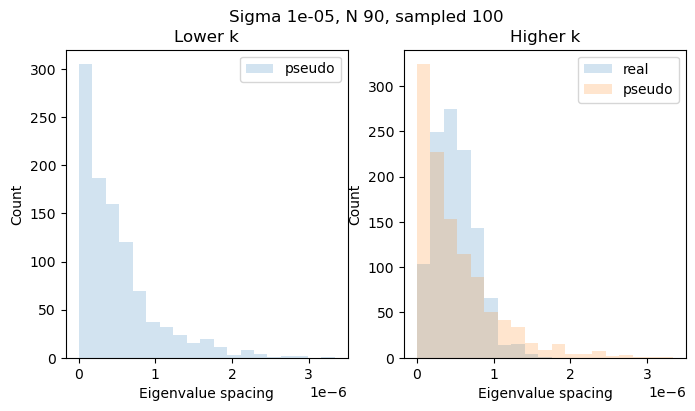

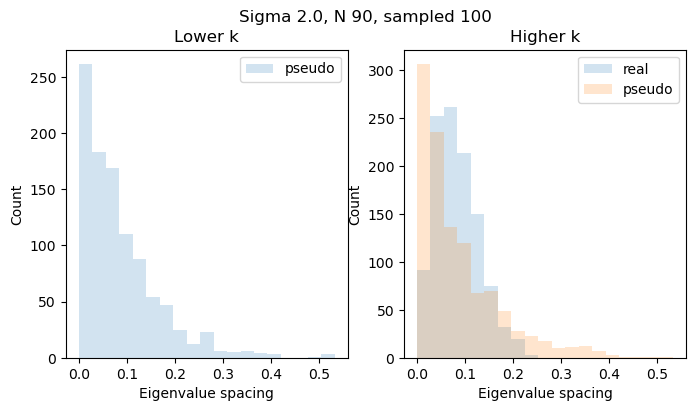

In [141]:
# (e) show numerically that eigenvalues of E are not iid

def get_eval_spacing(evals, k_range=[.2,.3]):
    evals = sorted(evals)
    n_evals = len(evals)
    k_min, k_max = int(k_range[0]*n_evals), int(k_range[1]*n_evals)
    s_k = []
    for k in range(k_min, k_max+1):
        s_k.append(evals[k]-evals[k-1])
    return s_k

def fit_exp_to_hist(bins, hist_data):
    bw = (bins[1]-bins[0])/2
    bin_centers = [b+bw for b in bins[:-1]]
    print(len(bin_centers), len(hist_data))
    # remove zeros 
    nz = [e for e,d in enumerate(hist_data) if d != 0]
    hist_data = hist_data[nz]
    bin_centers = np.array(bin_centers)[nz]
    popt, pcov = curve_fit(lambda t, a, b, c: a*np.exp(b*t) + c, bin_centers, hist_data)
    y_k = [popt[0]*np.exp(popt[1] * x) + popt[2] for x in bin_centers]
    return y_k, bin_centers
    

# sample an E 
N=90
n_samples = 100
sigmas = [0.00001, 2.0]
M = get_real_symmetric_orthogonal(rng, N=N, sigma=sigmas[0])

k_range1 = [.2,.3]
k_range2 = [.7, .8]
for sg in sigmas:
    s_k1 = []
    s_k2 = []
    all_evals = []
    for _ in range(n_samples):
        E = get_E_from_M(rng, M, sg, N) 
        # get eigenvalues and rank them 
        e_lamb, e_v = np.linalg.eigh(E)
        s_k1_s = get_eval_spacing(e_lamb, k_range1)
        s_k2_s = get_eval_spacing(e_lamb, k_range2)
        s_k1.extend(s_k1_s)
        s_k2.extend(s_k2_s)
        all_evals.extend(e_lamb)

    # make pseudo-iid samples
    n_evals = len(e_lamb)
    s_k1_rand = []
    s_k2_rand = []
    for _ in range(n_samples):
        pseudo_evals = rng.choice(all_evals, size=n_evals, replace=False)
        s_k1_rand_s = get_eval_spacing(pseudo_evals, k_range1)
        s_k2_rand_s = get_eval_spacing(pseudo_evals, k_range2)
        s_k1_rand.extend(s_k1_rand_s)
        s_k2_rand.extend(s_k2_rand_s)
        
    
    fig, ax = plt.subplots(1,2, figsize=(8,4))
    min_min, max_max = min(min(s_k1), min(s_k2), min(s_k1_rand), min(s_k1_rand)), max(max(s_k1), max(s_k2), max(s_k1_rand), max(s_k1_rand))
    bins = np.linspace(min_min, max_max, 20)
    hist_k1_rand = ax[0].hist(s_k1_rand, alpha=0.2, bins=bins, label='pseudo')
    ax[0].set_title('Lower k')
    hist_k2 = ax[1].hist(s_k2, alpha=0.2, bins=bins, label='real')
    hist_k2_rand = ax[1].hist(s_k2_rand, alpha=0.2, bins=bins, label='pseudo')
    ax[1].set_title('Higher k')
    for axs in ax:
        axs.set_ylabel('Count')
        axs.set_xlabel('Eigenvalue spacing')
        axs.legend()
    fig.suptitle(f'Sigma {sg}, N {N}, sampled {n_samples}')